<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/20231113_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트
* 콘텐츠 기반 필터링

**장르 속성을 이용한 영화 콘텐츠 기반 필터링**
* 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성, 구성 요소를 가진 다른 영화를 추천하는 것

**데이터 로딩 및 가공**

In [1]:
# dataframe 로딩 및 데이터 개략적으로 보기
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


-> 4803 레코드 & 20개 피처, 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출해 새로운 데이터프레임 생성 (id, title, genres, vote_average, vote_count, popularity, keywords, overview)

In [2]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]

* 일부 칼럼은 파이썬 리스트 내부에 여러 개의 딕셔너리가 있는 형태의 문자열 -> 칼럼 가공을 통해 필요한 정보만 추출

In [3]:
pd.set_option('max_colwidth',100)
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


-> genres는 여러 개의 개별 장르 데이터 소유, 개별 장르의 명칭은 'name'으로 추출 (keywords도 유사)
* literal_eval() 함수를 이용해 list[dict1,dict2] 객체로 변환

In [4]:
from ast import literal_eval
movies_df['genres']= movies_df['genres'].apply(literal_eval)
movies_df['keywords']= movies_df['keywords'].apply(literal_eval)

-> 리스트 값에서 장르 명만 리스트 객체로 추출

In [5]:
movies_df['genres'] = movies_df['genres'].apply(lambda x: [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: [y['name'] for y in x])
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


**장르 콘텐츠 유사도측정**
* 여러 장르가 복합적으로 되어 있을 때 장르 유사도 측정 방법: genres를 문자열로 변경한 뒤 countvectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교

In [6]:
# countvectorizer를 이용해 피처 벡터 행렬로 만들고 개별 요소를 공백 문자로 구분하는 문자열 생성
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환.
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x: (' ').join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


In [7]:
# cosine_similarity() 함수를 이용해 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


-> genre_literal 칼럼을 피처벡터화한 행렬 데이터의 행별 유사도 정보를 가지고 있음 (=movies_df의 행별 장르 유사도 값 가짐)
* genre_sim 객체의 기준 행별로 비교 대상이 되는 행의 유사도 값이 높은 순으로 정렬된 행렬의 위치 인덱스 값 추출 (argsort() 함수)

In [8]:
genre_sim_sorted_ind = genre_sim.argsort()[:,::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


-> 0번 레코드 : 자기 자신 제외, 3494번 레코드가 가장 유사도 높고 그 다음 813

**장르 콘텐츠 필터링을 이용한 영화 추천**
* find_sim_movie(): 장르 유사도에 따라 영화 추천 함수

In [9]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
  title_movie = df[df['title']==title_name]

  # title_named를 가진 DataFrame의 index 객체를 ndarray로 반환하고
  # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  # 추출된 top_n index 출력. top_n index는 2차원 데이터
  # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

-> find_sim_movie() 함수를 이용해 영화 '대부'와 장르별로 유사한 영화 10개 추천

In [10]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title','vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


-> 대부 2편, 좋은 친구들처럼 비슷한 유형도 있으나 낯선 영화도 있음
>
-> 좀 더 많은 후보군을 선정한 후에 영화의 평점에 따라 최종 추천
>
-> 0-10점까지 점수가 있는데 소수의 관객이 특정 영화에 만점이나 매우 높은 평점을 부여해 왜곡된 데이터 가짐

In [11]:
movies_df[['title','vote_average','vote_count']].sort_values('vote_average',ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


-> 낯선 영화가 소수의 관객에 의한 높은 평점으로 높은 순위에 있음
* 평가 횟수에 가중치가 부여된 평점인 가중 평점 이용
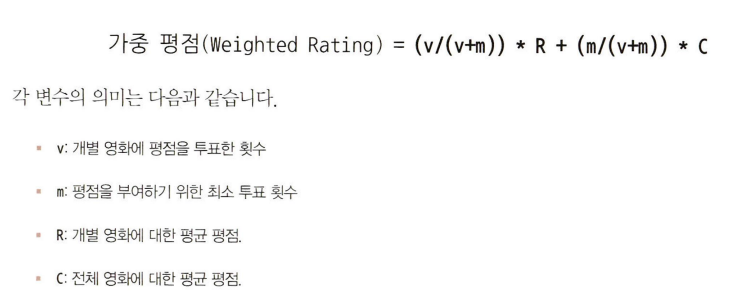

* m 값은 투표 횟수에 따른 가중치 조절 역할을 하는데 m 값을 높이면 평점 투표 횟수가 더 많은 영화에 더 많은 가중 평점 부여 (상위 60%값으로 설정)

In [12]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C,3),'m', round(m,3))

C: 6.092 m 370.2


* 기존 평점을 새로운 가중 평점으로 변경하는 함수를 생성, 이를 이용하 새로운 평점 정보인 'vote_weighted' 값 생성

In [13]:
percentile =0.6
m = movies['vote_count'].quantile(percentile)
C = movies['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ((v/(v+m))*R) + ((m/(m+v))*C)

movies['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [15]:
# weighted_vote 평점이 높은 순으로 상위 10개 추출
movies[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


* 새롭게 정의된 평점 기준에 따라 영화 추천

In [18]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes!= title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote',ascending=False)[:top_n]

similar_movies = find_sim_movie(movies, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title','vote_average','weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
